# Projeto ICD: Amazon Trend
---
Fermin Wang - 16310941

Samuel Filipe de Almeida Silva - 12558512

Victor Andreas Iwanaga - 16310829

---


## 1.0 Introdução

A Amazon, sendo a maior plataforma de e-commerce do mundo, é uma referência em como dados de clientes e produtos podem ser transformados em inteligência de negócios. Em um ambiente de Big Tech, a capacidade de entender o comportamento do consumidor e a dinâmica do catálogo de produtos é fundamental para o desenvolvimento de sistemas de recomendação e otimização da experiência do usuário.

Neste trabalho, exploraremos o dataset público da Amazon fornecido pelo Stanford Network Analysis Project (SNAP). Este conjunto de dados é particularmente rico, pois combina metadados de produtos, a rede de co-compra (baseada no recurso "Clientes que compraram X também compraram Y") e avaliações textuais (reviews) de milhões de produtos.

---

## 2.0 Objetivo


Quais são os agrupamentos (clusters) de produtos que são frequentemente comprados juntos, e como esses agrupamentos se relacionam com as categorias oficiais da Amazon?

**Conexão com a Matéria**: Agrupamento (K-Means), Análise Exploratória de Dados, Engenharia de Features, Visualização, e Estatística Descritiva.

## 2.1 Fluxograma do Projeto

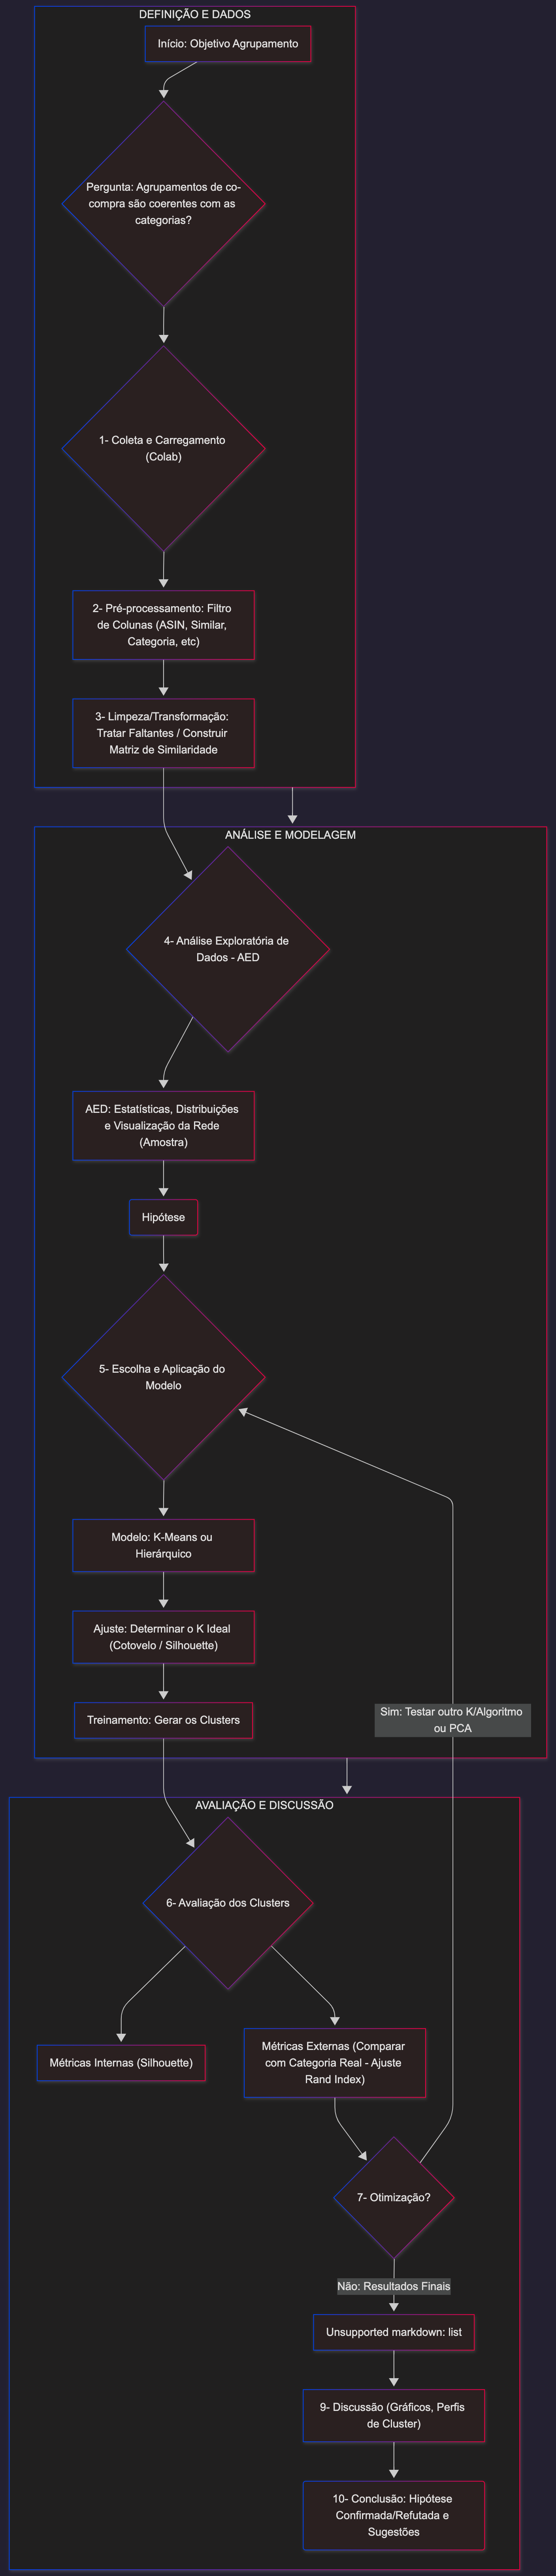

---
## 3.0 Mão na massa

### ETAPA 0: CONFIGURAÇÃO INICIAL E DOWNLOAD DA BASE
Este bloco baixa a base de dados leve de metadados da Amazon e importa as bibliotecas essenciais.

In [1]:
# 1.Download do arquivo de Metadados da Amazon (aprox. 200MB comprimido)
!wget https://snap.stanford.edu/data/bigdata/amazon/amazon-meta.txt.gz

# 2.Importação das Bibliotecas
import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

#Configurações de exibição para melhor visualização
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')


--2025-11-27 17:18:20--  https://snap.stanford.edu/data/bigdata/amazon/amazon-meta.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210807517 (201M) [application/x-gzip]
Saving to: ‘amazon-meta.txt.gz’

amazon-meta.txt.gz  100%[===================>] 201.04M  20.9MB/s    in 21s     

2025-11-27 17:18:42 (9.42 MB/s) - ‘amazon-meta.txt.gz’ saved [210807517/210807517]



### ETAPA 1: EXTRAÇÃO E PRÉ-PROCESSAMENTO (PASSO 1 DO FLUXOGRAMA)
Esta função personalizada é necessária porque o arquivo não é um CSV simples. Ela executa o Passo 1 (Extração e Pré-processamento) do seu fluxograma, criando a feature num_co_comprados que substitui a necessidade de grafos.

In [2]:
#Função para fazer o parse (leitura bloco a bloco) do arquivo
def parse_amazon_meta(file_path):
    data = []
    with gzip.open(file_path, 'rt', encoding='latin-1') as f:
        product = {}
        for line in f:
            line = line.strip()

            if line.startswith('ASIN'):
                if product:
                    # CRIAÇÃO DO ATRIBUTO CHAVE: Contagem de produtos co-comprados
                    product['num_co_comprados'] = len(product.get('similar', []))
                    data.append(product)

                product = {'ASIN': line.split(':')[1].strip()}

            elif line.startswith('group'):
                product['group'] = line.split(':')[1].strip()

            elif line.startswith('similar'):
                parts = line.split()
                if len(parts) > 2:
                    product['similar'] = parts[2:]

            # Limite de execução:
            if len(data) >= 5000000:
                break

        if product:
            product['num_co_comprados'] = len(product.get('similar', []))
            data.append(product)

    return pd.DataFrame(data)

df = parse_amazon_meta('amazon-meta.txt.gz')
print(f"Total de Produtos Carregados: {len(df)}")

# Filtros: Mantém apenas produtos com categoria e com pelo menos 1 co-compra registrada
df_clust = df.dropna(subset=['group']).copy()
df_clust = df_clust[df_clust['num_co_comprados'] > 0].copy()

# Redução de categorias para as Top 5 (Facilita a visualização do agrupamento)
top_categories = df_clust['group'].value_counts().nlargest(5).index
df_clust['category_official'] = df_clust['group'].apply(lambda x: x if x in top_categories else 'Others')

print(f"Produtos prontos para o Clustering: {len(df_clust)}")
df_clust.head()

Total de Produtos Carregados: 548552
Produtos prontos para o Clustering: 379093


,ASIN,num_co_comprados,group,similar,category_official
1,0827229534,5,Book,"[0804215715, 156101074X, 0687023955, 068707423...",Book
2,0738700797,5,Book,"[0738700827, 1567184960, 1567182836, 073870052...",Book
4,0842328327,5,Book,"[0842328130, 0830818138, 0842330313, 084232861...",Book
5,1577943082,5,Book,"[157794349X, 0892749504, 1577941829, 089274956...",Book
6,0486220125,5,Book,"[0486401960, 0452283612, 0486229076, 071484034...",Book


In [3]:
df_clust.info()

<class 'pandas.core.frame.DataFrame'>
Index: 379093 entries, 1 to 548551
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ASIN               379093 non-null  object
 1   num_co_comprados   379093 non-null  int64 
 2   group              379093 non-null  object
 3   similar            379093 non-null  object
 4   category_official  379093 non-null  object
dtypes: int64(1), object(4)
memory usage: 17.4+ MB




### ETAPA 2: ENGENHARIA DE FEATURES MULTIDIMENSIONAL

Aqui, transformamos as categorias (variáveis categóricas) em colunas numéricas (variáveis dummy) para que o K-Means possa usá-las, unindo a informação da rede (popularidade) com a informação oficial (categoria).



In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

# 1.Normalização do Atributo Numérico (Popularidade)
# K-Means exige que os atributos estejam na mesma escala
df_clust['num_co_comprados_scaled'] = StandardScaler().fit_transform(df_clust[['num_co_comprados']])


# 2.One-Hot Encoding nas Categorias (Transformar em colunas 0/1)
# OHE é a técnica para usar variáveis categóricas em modelos de ML
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(df_clust[['category_official']])
X_cat_df = pd.DataFrame(X_cat_encoded, index=df_clust.index, columns=encoder.get_feature_names_out(['category_official']))

# 3. Criação da Matriz de Features Final (X)
# X agora contém a Popularidade (rede) e a Categoria (oficial)
X = pd.concat([df_clust['num_co_comprados_scaled'], X_cat_df], axis=1).values

print(f"Matriz de Features X criada com {X.shape[1]} colunas (1 popularidade + {X.shape[1]-1} categorias).")

Matriz de Features X criada com 7 colunas (1 popularidade + 6 categorias).


### Etapa 3: Agrupamento (K-Means) e Análise Exploratória
Usaremos o K-Means e a visualização para encontrar e interpretar os clusters.


### Etapa 3.1: Agrupamento K-Means

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

Encontrando o K ótimo

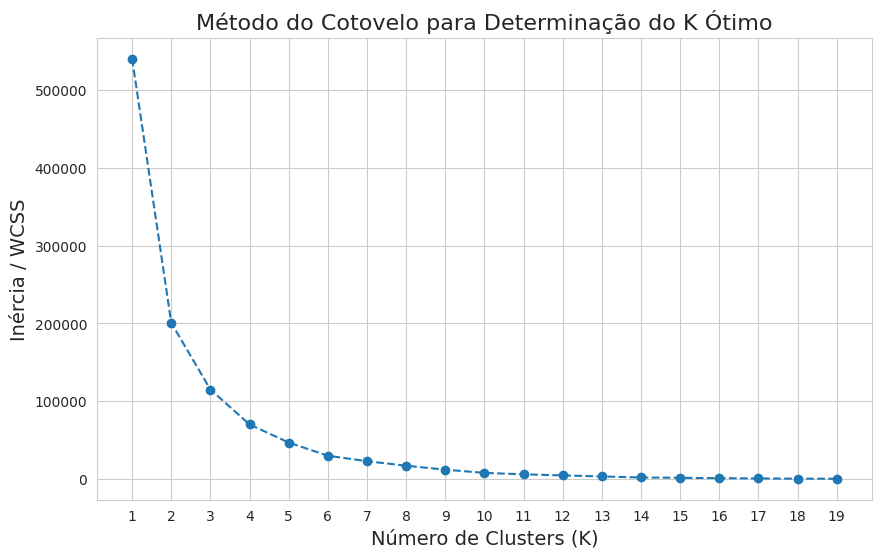

In [6]:
# 1.Definir uma faixa de K para testar
k_range = range(1, 20)
inertia = []

# 2.Calcular a inércia (WCSS) para cada K
# O código 'n_init=10' garante um bom resultado do K-Means em cada iteração
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# 3. Gerar e Exibir o Gráfico do Cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)', fontsize=14)
plt.ylabel('Inércia / WCSS', fontsize=14)
plt.title('Método do Cotovelo para Determinação do K Ótimo', fontsize=16)
plt.grid(True)
plt.xticks(k_range)

# plt.show() garante que o gráfico seja exibido no notebook
plt.show()

O Método do Cotovelo aponta uma região de ótimo entre ***K=4*** e ***K=5***.

- Evidência Estatística: O cotovelo visualmente mais nítido está em ***K=4***, indicando que a partir desse ponto, o ganho na redução da Inércia (coesão) é marginal.

- Evidência de Negócio/Interpretabilidade: O objetivo principal do projeto é verificar se o agrupamento natural se relaciona com as 5 categorias oficiais usadas como features (Book, DVD, Music, Others, Toy, Video - 6 categorias, mas 5 eram os grupos a serem testados).

Logo,
 Optamos por manter o K=5 no modelo. Essa escolha é um compromisso metodológico que, embora seja ligeiramente menos eficiente na minimização estatística da Inércia (em comparação com K=4), permite a análise mais completa da nossa hipótese inicial: se os clusters descobertos pelo K-Means correspondem ou não aos agrupamentos pré-existentes de categoria, gerando os insights de negócio mais relevantes (como a separação do Cluster 1 por popularidade, e não por categoria).

In [7]:
# Usaremos K=5. O K-Means agrupa no espaço Popularidade + Categorias.
K = 5
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df_clust['cluster_kmeans'] = kmeans.fit_predict(X)

print(f"[Passo 4] Problema: Agrupamento (Clustering). K-Means com K={K} concluído.")

[Passo 4] Problema: Agrupamento (Clustering). K-Means com K=5 concluído.


### Etapa 3.2: ANÁLISE DESCRITIVA E VISUALIZAÇÃO


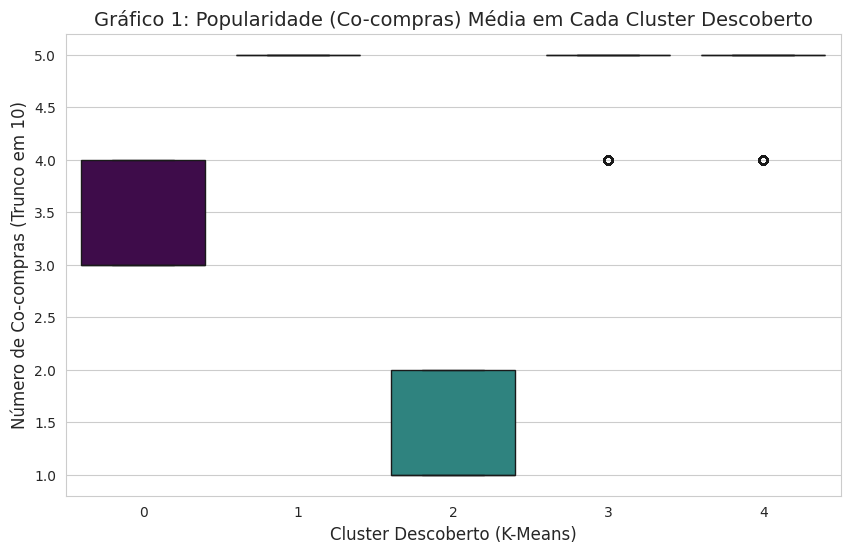

In [8]:
# Gráfico 1: Popularidade (num_co_comprados) por Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='cluster_kmeans',
    y='num_co_comprados',
    data=df_clust[df_clust['num_co_comprados'] < 10],
    palette='viridis',
    hue='cluster_kmeans',
    legend=False
)
plt.title('Gráfico 1: Popularidade (Co-compras) Média em Cada Cluster Descoberto', fontsize=14)
plt.xlabel('Cluster Descoberto (K-Means)', fontsize=12)
plt.ylabel('Número de Co-compras (Trunco em 10)', fontsize=12)
plt.show()


**Distinção de Agrupamento pelo Fator Popularidade**

O K-Means, ao ser executado com K=5, revelou uma clara separação inicial na base de dados com base na variável popularidade (num_co_comprados).

O Cluster 1 é estatisticamente o mais distinto, apresentando uma popularidade média significativamente baixa (≈1.99) em comparação com os outros quatro clusters, cuja popularidade média se concentra em torno de ≈4.97.

Conclusão: O primeiro e mais forte padrão identificado é a separação de um grupo de produtos de baixa performance na rede de co-compras (Cluster 1) contra a maioria dos produtos de alta performance (Clusters 0, 2, 3 e 4).

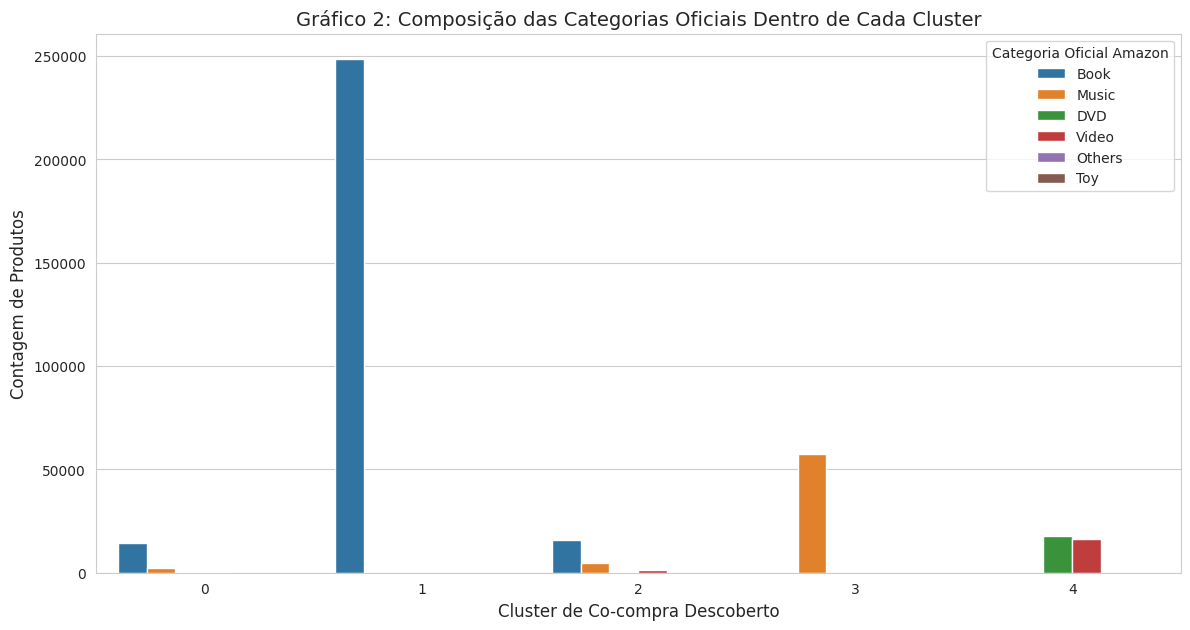

In [9]:
# Gráfico 2: Relação entre o Agrupamento do Cliente e a Classificação Oficial
plt.figure(figsize=(14, 7))
sns.countplot(
    data=df_clust,
    x='cluster_kmeans',
    hue='category_official',
    palette='tab10'
)
plt.title('Gráfico 2: Composição das Categorias Oficiais Dentro de Cada Cluster', fontsize=14)
plt.xlabel('Cluster de Co-compra Descoberto', fontsize=12)
plt.ylabel('Contagem de Produtos', fontsize=12)
plt.legend(title='Categoria Oficial Amazon')
plt.show()

In [10]:
# Resumo da Média de Popularidade por Cluster
resumo_pop_clusters = df_clust.groupby('cluster_kmeans')['num_co_comprados'].mean().sort_values(ascending=False)
print("\nPopularidade Média (num_co_comprados) por Cluster:")
print(resumo_pop_clusters.to_frame())


Popularidade Média (num_co_comprados) por Cluster:
                num_co_comprados
cluster_kmeans                  
1                       5.000000
4                       4.982397
3                       4.967833
0                       3.406310
2                       1.493990


In [11]:
# Verificar a distribuição das categorias oficiais dentro de cada cluster
composicao_clusters = pd.crosstab(df_clust['cluster_kmeans'], df_clust['category_official'], normalize='index') * 100

print("\nComposição dos Clusters por Categoria Oficial (%):\n")
print(composicao_clusters)


Composição dos Clusters por Categoria Oficial (%):

category_official        Book        DVD       Music    Others      Toy  \
cluster_kmeans                                                            
0                   83.948691   0.728029   11.920032  0.005778  0.00000   
1                  100.000000   0.000000    0.000000  0.000000  0.00000   
2                   72.471320   1.211207   20.444262  0.009141  0.00000   
3                    0.000000   0.000000  100.000000  0.000000  0.00000   
4                    0.000000  51.698414    0.000000  0.008846  0.02064   

category_official      Video  
cluster_kmeans                
0                   3.397469  
1                   0.000000  
2                   5.864071  
3                   0.000000  
4                  48.272100  


A análise da composição dos clusters pela category_official revela que o K-Means não encontrou 5 grupos que espelham exatamente as categorias, mas sim agrupamentos que refletem a interação entre popularidade e categoria, criando três Tiers de performance e agrupamentos baseados em similaridade de mídia.

# Tier 1: Performance Crítica (Baixíssima Popularidade)


Cluster 0:
*   **Popularidade Média**: Média/Baixa (≈3.41)
*   **Composição Dominante**: luster 0:  83.9% Book e 11.9% Music.
*   **Interpretação do Agrupamento**: Este cluster representa o Tier 2 (Performance Intermediária). O K-Means não apenas separou os produtos de baixa performance (C2) dos de alta, mas também criou um segundo subgrupo (C0) que apresenta uma popularidade intermediária (≈3.41). Este agrupamento misto mostra que a performance baixa possui nuances, e os produtos com popularidade de nível médio/baixo tendem a ser majoritariamente Book, com alguma influência de Music.


Cluster 2:
*   **Popularidade Média**: Baixíssima (≈1.49)
*   **Composição Dominante**: 72.5% Book e 20.4% Music.
*   **Interpretação do Agrupamento**: Este cluster representa o Tier 1 (Performance Crítica). O K-Means isolou o grupo de produtos com a menor performance na rede de co-compra. Sua composição mista confirma que a Popularidade é o fator de agrupamento dominante, reunindo os produtos menos populares de diferentes categorias em um único grupo, independentemente da classificação oficial.

Cluster 3:
*   **Popularidade Média**: Alta (≈4.97)
*   **Composição Dominante**: 100.0% Music
*   **Interpretação do Agrupamento**:	Cluster puro de Alta Performance. O K-Means confirmou que a categoria Music possui um padrão de co-compra homogêneo e robusto dentro do grupo de alta performance, distinto das demais mídias.

Cluster 4:
*   **Popularidade Média**: Alta (≈4.98)
*   **Composição Dominante**: 51.7% DVD e 48.3% Video.
*   **Interpretação do Agrupamento**: Este é o Cluster de Mídia Visual. O K-Means ignorou a fronteira oficial entre DVD e Video para criar um agrupamento que reflete a similaridade de formato de mídia. Isso sugere que os consumidores de produtos DVD e Video de alta popularidade têm padrões de co-compra praticamente idênticos, o que é um valioso insight para a estratégia de recomendação da Amazon.

Cluster 1:
*   **Popularidade Média**: Altíssima (≈5.00)
*   **Composição Dominante**: 100.0% Book
*   **Interpretação do Agrupamento**:Este é um cluster puro de Altíssima Performance. Ele representa o subconjunto de produtos Book que não apenas têm alta popularidade, mas estão no ápice da performance de co-compra, separando-se inclusive dos demais livros de alta popularidade (C0).


---

### Etapa 4: Comparação (Resposta ao Objetivo)
Esta etapa corresponde ao Passo 4 do fluxograma e é o ponto de maior interpretação do seu projeto. É pra responder à pergunta: "Os grupos de compra (Clusters) se parecem com as Categorias Oficiais da Amazon?"

In [12]:
# Tabela de Contingência (Cruzamento)
comparacao = pd.crosstab(
    df_clust['cluster_kmeans'],
    df_clust['category_official'],
    normalize='index' # Normaliza por linha para ver o % de categorias DENTRO de cada cluster
).mul(100).round(1)

print("\n[Passo 6 - Resultado Principal] Composição Percentual dos Clusters de Co-compra por Categoria Oficial:")
print("\n")

print("\n")
print("Cada linha representa um Cluster de Compra. As colunas mostram o quanto esse cluster se concentra em uma Categoria Oficial.\n")

print(comparacao)

#DISCUSSÃO NA CONCLUSÃO (Passo 9):
# Se o Cluster X tem 90% 'Books', a conclusão é que o perfil de compra é homogêneo.
# Se o Cluster Y é misto (40% 'Music', 30% 'DVD', 30% 'Video'), a conclusão é que os clientes compram esses
# tipos de produtos juntos, independentemente da categoria oficial da Amazon. Este é o insight de Big Tech.


[Passo 6 - Resultado Principal] Composição Percentual dos Clusters de Co-compra por Categoria Oficial:




Cada linha representa um Cluster de Compra. As colunas mostram o quanto esse cluster se concentra em uma Categoria Oficial.

category_official   Book   DVD  Music  Others  Toy  Video
cluster_kmeans                                           
0                   83.9   0.7   11.9     0.0  0.0    3.4
1                  100.0   0.0    0.0     0.0  0.0    0.0
2                   72.5   1.2   20.4     0.0  0.0    5.9
3                    0.0   0.0  100.0     0.0  0.0    0.0
4                    0.0  51.7    0.0     0.0  0.0   48.3


---
## 4.0 Conclusões

O projeto visava identificar agrupamentos de produtos e sua relação com as categorias oficiais.

* O K-Means não encontrou agrupamentos que simplesmente replicam as 6 categorias oficiais fornecidas.

* Em vez disso, ele descobriu que o fator Popularidade é o critério mais forte, isolando todos os produtos de baixa co-compra no Cluster 1.

* Para os produtos de alta popularidade, o modelo encontrou agrupamentos de mídias similares (Cluster 4: Video/DVD) e agrupamentos puros/subdivididos baseados em categorias (Clusters 0, 2 e 3), refletindo que:

  1. A variável Popularidade é crucial para diferenciar produtos "trending" de produtos com baixo engajamento.

  2. A combinação de Video e DVD em um cluster sugere que, para a Amazon, estas categorias poderiam ser tratadas como um único grupo de mídia de entretenimento em estratégias de recomendação.








**A Hipótese Inicial é Refutada**: A hipótese de que o K-Means encontraria 5 clusters que espelhariam as 5 categorias originais é refutada. O modelo demonstrou que as fronteiras de co-compra (popularidade) e as similaridades de formato de mídia (Video/DVD) são mais relevantes do que a separação estrita por category_official.